# Modeling

In this notebook, our aims is to find an accurate model for our data. With this model, we can find business solutions about house prices. 

To do this, we have some steps;
- Discover linearity , collinearity between columns
- Discover highly correlated columns with price
- Decide the metric for models 
- Try different transformations, regressions, scalers, models
- According to our metric,compare them and find the best models 
- Guess some specific models such as special for zipcodes

# Importing Necessary Libraries

In [1]:
# Array and Dataframe
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Statistical and modeling libraries
import scipy.stats as stats
import math
import random

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import quantile_transform, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

from pygam import LinearGAM

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('clean_data.csv') # to take our clean data to date frame

In [3]:
df.drop(columns='Unnamed: 0',inplace=True) # to get rid of uncessary extra column

In [4]:
pd.options.display.max_columns=100 # to see all columns

# First Look for Correlations

To develop a model, correlations are very important. Because, highly correlated columns affect prices. To invest, which columns are very important in our data, we plot correlation matrix. 

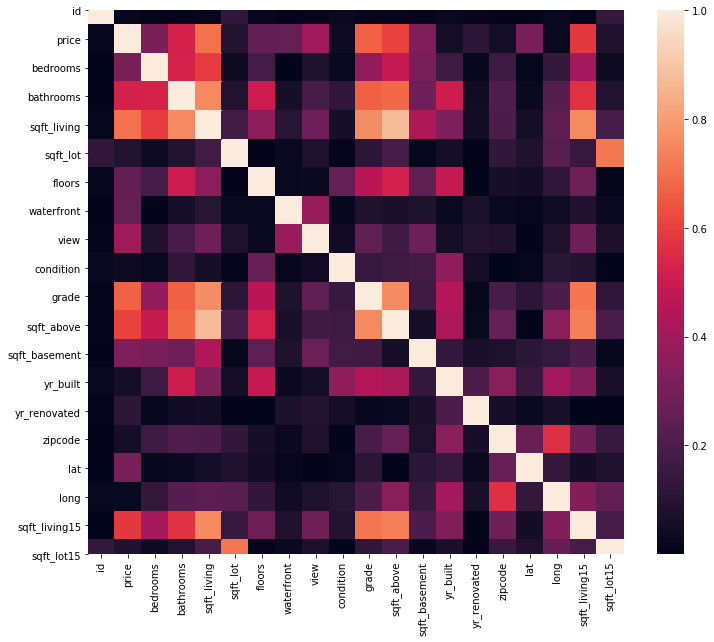

In [5]:
plt.figure(figsize = (12,10))
sns.heatmap(df.corr().abs())    # To see the correlations
plt.show() 

Also, we want to see numeric values. To do this and also use for modelling, we divided our target column 'price' from whole data set.

In [6]:
target = "price"
used_cols = [c for c in df.columns.to_list() if c not in [target]] # all columns except price

# assign all columns except price new df as X and 'price' is y
X = df[used_cols]
y = df[target]

In [7]:
df.corr()[target].abs().sort_values(ascending=False) #to see the numeric values for correlations

price            1.000000
sqft_living      0.701587
grade            0.668307
sqft_above       0.605695
sqft_living15    0.585304
bathrooms        0.525053
view             0.395734
sqft_basement    0.321816
bedrooms         0.315229
lat              0.307868
waterfront       0.259220
floors           0.257052
yr_renovated     0.117982
sqft_lot         0.090338
sqft_lot15       0.083189
yr_built         0.054273
zipcode          0.053620
condition        0.035393
long             0.022417
id               0.017392
Name: price, dtype: float64

# First Step to Baseline Determination for Model

First of all, we need to decide our baseline. In this notebook, we will use pipeline for modeling steps. Because, we will try different transformations, scalers etc. to find the best results. So, we created pipeline and use this pipeline generally. 

Out metric is R^2 for this project. Just to see errors , we also find negative mean squared errors. But we will decide our model according to R^2. Because R^2 shows that how close the data is to the fitted regression and our model.

To get a good results, we use cross validation. We choose cv as 3, it gives 3 different results for each trial. We get and use mean of them. This application will give us more accurate results. Instead of train-test splits, we prefer cross validation which splitting train-test itself and do it for 3 times. 

For the first trial we use Robust Scaler as a scaler. Robust scales variables using statistics that are strong to outliers. In our dataset, we have many outliers. If we clean all of them, we can lose lots of data points. Instead of dropping all of them, firstly we scale them. Robust Scaler use IQR(Interquartile Range) and the interquartile range generally give better results fot these type of data.

In [8]:
# Linear Regression with pipeline

scaler = RobustScaler()    
lr = LinearRegression()
pipe1 = make_pipeline(scaler, lr)

metrics = ['r2', 'neg_mean_squared_error'] # we will use R2 as metric generally
    
c_v = cross_validate(pipe1, X, y, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

In [9]:
sorted(c_v.keys()) # to reach the our results, because c_v gives dictionary

['fit_time',
 'score_time',
 'test_neg_mean_squared_error',
 'test_r2',
 'train_neg_mean_squared_error',
 'train_r2']

To see the results we write a function for printing. 

In [10]:
def print_results (c_v):
    test = c_v['test_r2'].mean()  
    train= c_v['train_r2'].mean()  
    
    print (f'test r2 is {test}')
    print (f'train r2 is {train}')

    test_MSE = c_v['test_neg_mean_squared_error'].mean()  
    train_MSE = c_v['train_neg_mean_squared_error'].mean() 

    print (f'test NEG MSE is {test_MSE}')
    print (f'train NEG MSE is {train_MSE}')
    
    return c_v

In [11]:
print_results(c_v)

test r2 is 0.6954963579543829
train r2 is 0.7014500841259426
test NEG MSE is -40758506733.6965
train NEG MSE is -39993008512.35435


{'fit_time': array([0.08410597, 0.07979107, 0.07988882]),
 'score_time': array([0.01002979, 0.00833702, 0.00685096]),
 'test_r2': array([0.69825846, 0.69247075, 0.69575986]),
 'train_r2': array([0.70065807, 0.70398594, 0.69970625]),
 'test_neg_mean_squared_error': array([-4.13376855e+10, -4.02826672e+10, -4.06551676e+10]),
 'train_neg_mean_squared_error': array([-3.96562794e+10, -4.00822592e+10, -4.02404870e+10])}

Also we created new dataframe to see all trials and compare them.

In [53]:
df_results = pd.DataFrame(columns=["Model", "Info",'Test R^2','Train R^2','Pseudo R^2']) # to see all results 

In [54]:
df_results = df_results.append({       # first trial is written in results 
     "Model": 'Linear Regression' ,
      "Info": 'All columns' , 
       'Test R^2' : 0.6955,
        'Train R^2' : 0.7014,
            'Pseudo R^2' : '-'}, ignore_index=True)

For the first simple trial, we find our R^2 values near to each other. Nearest train and test data R^2 values means better results. But our general R^2 is not very near to 1. So, we continue to improve it.

### Changing Scaler

In [14]:
scaler = MinMaxScaler()    
lr = LinearRegression()
pipe2 = make_pipeline(scaler, lr)

c_v2 = cross_validate(pipe2, X, y, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

In [15]:
print_results(c_v2)

test r2 is 0.6954963579543834
train r2 is 0.7014500841259427
test NEG MSE is -40758506733.696434
train NEG MSE is -39993008512.35433


{'fit_time': array([0.03691268, 0.03104711, 0.04500079]),
 'score_time': array([0.00738525, 0.00908804, 0.01137805]),
 'test_r2': array([0.69825846, 0.69247075, 0.69575986]),
 'train_r2': array([0.70065807, 0.70398594, 0.69970625]),
 'test_neg_mean_squared_error': array([-4.13376855e+10, -4.02826672e+10, -4.06551676e+10]),
 'train_neg_mean_squared_error': array([-3.96562794e+10, -4.00822592e+10, -4.02404870e+10])}

We check our results with using MinMax Scaler and there is no significant change. So, we continue to scale our data with RobustScaler which is more suitable to our outliers.

## Let’s Dig Deeper on 'sq_ft living'

Square_ft living area is our most related column with prices. So, we deep into for exploring features.

In [16]:
df['sqft_living'].describe()

count    21534.000000
mean      2079.827854
std        917.446520
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

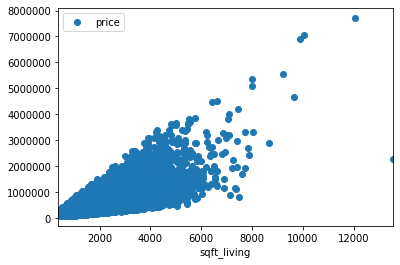

In [17]:
df.plot(x='sqft_living', y='price',style='o')

It is easily seen that there is positive linear correlation between price and living area. 

From the graph we can understand that there are some outliers such as area is higher than 13000 but lower price.
This column is the most related column with our target. So , we decided to clean some rows which has higher area than 
8000 sqft. We choose 8000 because generally our data points are belower than this value.

In [18]:
df1 = df[df['sqft_living'] < 8000] # we do not want to change our raw dataframe so assigning new one.

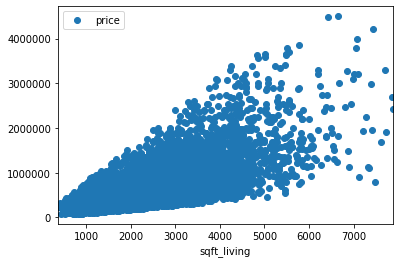

In [19]:
df1.plot(x='sqft_living', y='price',style='o')

Now, we have more good spread data.

In [20]:
target = "price"
used_cols = [c for c in df1.columns.to_list() if c not in [target]] # all columns except price

# assign all columns except price new df as X and 'price' is y
X1 = df1[used_cols]
y1 = df1[target]

scaler = RobustScaler()    
lr = LinearRegression()
pipe3 = make_pipeline(scaler, lr)

c_v3 = cross_validate(pipe3, X1, y1, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

In [21]:
print_results(c_v3)

test r2 is 0.7003383486337086
train r2 is 0.7059533828205039
test NEG MSE is -36849724118.42468
train NEG MSE is -36175444458.317024


{'fit_time': array([0.0475378 , 0.05309606, 0.048841  ]),
 'score_time': array([0.01066303, 0.00830197, 0.0096941 ]),
 'test_r2': array([0.70774434, 0.69879616, 0.69447455]),
 'train_r2': array([0.70296984, 0.70734129, 0.70754902]),
 'test_neg_mean_squared_error': array([-3.54914034e+10, -3.47625145e+10, -4.02952545e+10]),
 'train_neg_mean_squared_error': array([-3.67861471e+10, -3.71034271e+10, -3.46367592e+10])}

We run our model with new dataframe without living area < 8000 sqft. And find better results from previous when we drop the outliers of most correlated column.

In [55]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Linear Regression' ,
      "Info": 'All col. without >8000 sq_ft' , 
       'Test R^2' : 0.7003,
        'Train R^2' : 0.7059,
            'Pseudo R^2' : '-'}, ignore_index=True)

# Deep Into 'grade' Columns

Grade column is the second correlated column with prices. So, we will do some differences on it and try to understand effect of these differences. Firstly, we look at our column to understand general tendency.

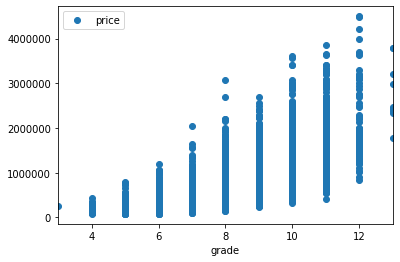

In [24]:
df1.plot(x='grade', y='price', style='o')

In [25]:
df1['grade'].value_counts()

7     8948
8     6053
9     2604
6     2031
10    1130
11     395
5      242
12      84
4       27
13       9
3        1
Name: grade, dtype: int64

From the first look, we understood that many of houses has 7 grades, 13 is very less and 3 is just one house.
But we want to check median prices for houses according to grades. To do this, we create a pivot table and graph.

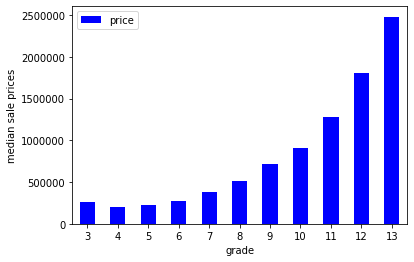

In [33]:
grade_pivot = df1.pivot_table(index='grade', values='price', aggfunc=np.median) # crating pivot table for median

grade_pivot.plot(kind='bar', color='blue')
plt.xlabel('grade')
plt.ylabel('median sale prices')
plt.xticks(rotation=0)
plt.show()


Median prices for 13 is significantly higher than others. So, we decided to encode this columns, and try model again.
Because it is the second correlated column with our prices. With adding new encoded column, our R^2 can change.

In [28]:
# We want to keep our dataframes in each step to come back easily. So , assing new data frame and we will use it

df2 = df1.copy()

In [30]:
def encode(x):    # assign 1 for 13, for others assign 0
    return 1 if x == 13 else 0

df2['enc_grade'] = df2['grade'].apply(encode)
 

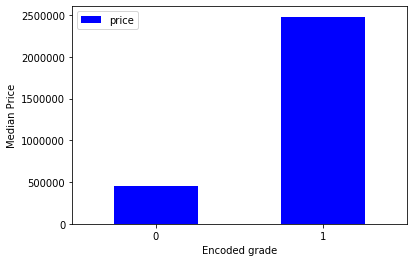

In [36]:
# to see encoded plot
grade_pivot = df2.pivot_table(index='enc_grade', values='price', aggfunc=np.median)
grade_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded grade')
plt.ylabel('Median Price')
plt.xticks(rotation=0)
plt.show()

In [39]:
used_cols2 = [c for c in df2.columns.to_list() if c not in [target]]

X2 = df2[used_cols2]
y2 = df2[target]

pipe4 = make_pipeline(scaler, lr)
    
c_v4 = cross_validate(pipe4, X2, y2, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

In [40]:
print_results(c_v4)

test r2 is 0.7027535380265387
train r2 is 0.7086357560892281
test NEG MSE is -36555763996.1179
train NEG MSE is -35846136563.54593


{'fit_time': array([0.0573051 , 0.05288386, 0.05618405]),
 'score_time': array([0.00678992, 0.00628924, 0.00890589]),
 'test_r2': array([0.71016636, 0.70173481, 0.69635944]),
 'train_r2': array([0.70562563, 0.70979625, 0.71048539]),
 'test_neg_mean_squared_error': array([-3.51972743e+10, -3.44233585e+10, -4.00466592e+10]),
 'train_neg_mean_squared_error': array([-3.64572368e+10, -3.67921860e+10, -3.42889869e+10])}

In [56]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Linear Regression' ,
      "Info": 'with encoded grade w/o >8000 sq_ft' , 
       'Test R^2' : 0.7028,
        'Train R^2' : 0.7086,
            'Pseudo R^2' : '-'}, ignore_index=True)

When we dropped outliers of sqft living and encoded grade, we found better results than baseline. So, we can continue to upgrade.

In [44]:
df3 = df2.copy()

df3.drop(columns=['sqft_above','sqft_basement'],inplace=True)

# These two columns affects our total sqft because of multicollinearity. So, we dropped them and try again. 

In [45]:
used_cols3 = [c for c in df3.columns.to_list() if c not in [target]]

X3 = df3[used_cols3]
y3 = df3[target]

pipe5 = make_pipeline(scaler, lr)
    
c_v5 = cross_validate(pipe5, X3, y3, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)
print_results(c_v5)

test r2 is 0.7025401330629494
train r2 is 0.7081429625050298
test NEG MSE is -36581577713.15112
train NEG MSE is -35906707867.25291


{'fit_time': array([0.05383396, 0.05462599, 0.05332184]),
 'score_time': array([0.00712705, 0.00582409, 0.00588298]),
 'test_r2': array([0.70933072, 0.70184016, 0.69644952]),
 'train_r2': array([0.70541117, 0.70914193, 0.70987579]),
 'test_neg_mean_squared_error': array([-3.52987543e+10, -3.44112005e+10, -4.00347784e+10]),
 'train_neg_mean_squared_error': array([-3.64837973e+10, -3.68751408e+10, -3.43611855e+10])}

In [57]:
df_results = df_results.append({       # keeping the results in result_df
     "Model": 'Linear Regression' ,
      "Info": 'with enc_grade, w/o >8000ft w/o sqft_above&basement',
       'Test R^2' : 0.7025,
        'Train R^2' : 0.7081,
            'Pseudo R^2' : '-'}, ignore_index=True)

There is no significant difference with these columns or without these columns. So,we decided not to drop them in this stage. So, we can use previous dataframe.

# CLEANED UNTIL HERE !!!

## Tranforming Data 

In [196]:
X_transformed = pd.DataFrame(quantile_transform(X1, n_quantiles=20, # see... binning again! 
                                                output_distribution='normal', 
                                                random_state=42), 
                             columns=used_cols1)

X_transformed.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,enc_grade
0,0.607335,-0.336038,-1.252120,-1.101506,-0.513412,-5.199338,-5.199338,-5.199338,-0.406724,-0.479506,-0.704369,-5.199338,-0.554923,-5.199338,1.642538,-0.445052,-0.085338,-1.030514,-0.512696,-5.199338
1,0.446100,-0.336038,0.066012,0.690751,-0.118923,0.804596,-5.199338,-5.199338,-0.406724,-0.479506,0.641338,0.490922,-0.699547,3.226360,0.855373,1.188697,-0.591201,-0.249943,0.003288,-5.199338
2,0.334556,-1.412188,-1.252120,-1.795367,0.556125,-5.199338,-5.199338,-5.199338,-0.406724,-1.412188,-1.717274,-5.199338,-1.127221,-5.199338,-0.835371,1.427873,0.007157,1.066239,0.160742,-5.199338
3,-0.523515,0.716498,1.252120,0.054978,-0.704369,-5.199338,-5.199338,-5.199338,5.199338,-0.479506,-1.030806,1.178502,-0.253347,-5.199338,1.047787,-0.389392,-1.646198,-0.976236,-0.734487,-5.199338
4,-0.745040,-0.336038,-0.132313,-0.294441,0.129840,-5.199338,-5.199338,-5.199338,-0.406724,0.406724,0.150484,-5.199338,0.371149,-5.199338,0.066012,0.236126,1.083835,-0.066012,-0.049675,-5.199338


In [119]:
transformer = QuantileTransformer(n_quantiles=20, output_distribution='normal', random_state=42)
lr = LinearRegression()
pipe3 = make_pipeline(transformer, lr)
cv3 = cross_validate(pipe3, X_transformed, y1, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)


# scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')
# print("R^2:", scores.mean(), "+/-", scores.std())

In [197]:
cv3['test_r2'].mean()

0.5939818022106688

## Ridge

In [198]:
lr = Ridge(alpha=0.025)

pipe4 = make_pipeline(scaler, lr)
cv4 = cross_validate(pipe4, X1 , y1, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

test = cv4['test_r2'].mean()  
train= cv4['train_r2'].mean()  
    
print (f'test r2 is {test}')
print (f'train r2 is {train}')

test r2 is 0.7027579651438348
train r2 is 0.7086357010537601


## Lasso

In [199]:
lasso = Lasso(alpha=0.1)
pipe5 = make_pipeline(scaler, lasso)
cv5 = cross_validate(pipe5, X1 , y1, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

test = cv5['test_r2'].mean()  
train= cv5['train_r2'].mean()  
    
print (f'test r2 is {test}')
print (f'train r2 is {train}')

test r2 is 0.7027537669202184
train r2 is 0.7086357558586581


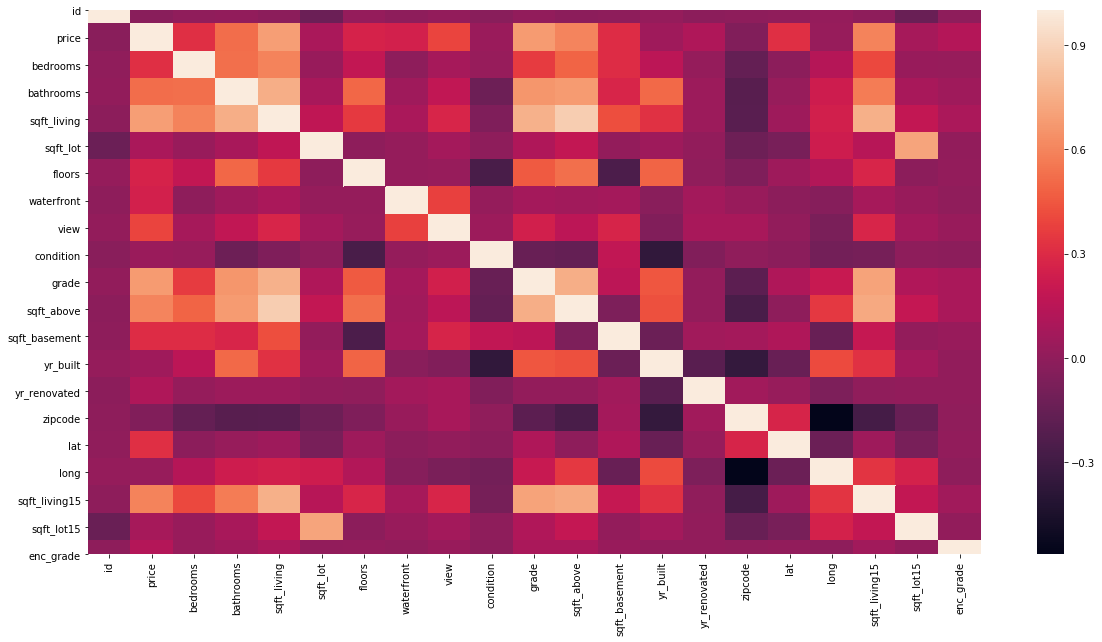

In [200]:
plt.figure(figsize = (20,10))
sns.heatmap(df2.corr()) # add to abs.

In [201]:
# best first pass approach to dealing with multicolinearity:

df3['sqft_liv_bathrooms'] = 0.5*df3['sqft_living'] + 0.5*df3['bathrooms']


In [202]:
df3.drop(columns=['sqft_living','bathrooms'],inplace=True)

In [203]:
used_cols2 = [c for c in df3.columns.to_list() if c not in [target]]

X2 = df3[used_cols2]
y2 = df3[target]
scaler = RobustScaler()
lr = LinearRegression()
pipe2 = make_pipeline(scaler, lr)
    
cv2 = cross_validate(pipe2, X2, y2, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

test = cv2['test_r2'].mean()  
train= cv2['train_r2'].mean()  
    
print (f'test r2 is {test}')
print (f'train r2 is {train}')

test r2 is 0.7006279459239124
train r2 is 0.7061428828997913


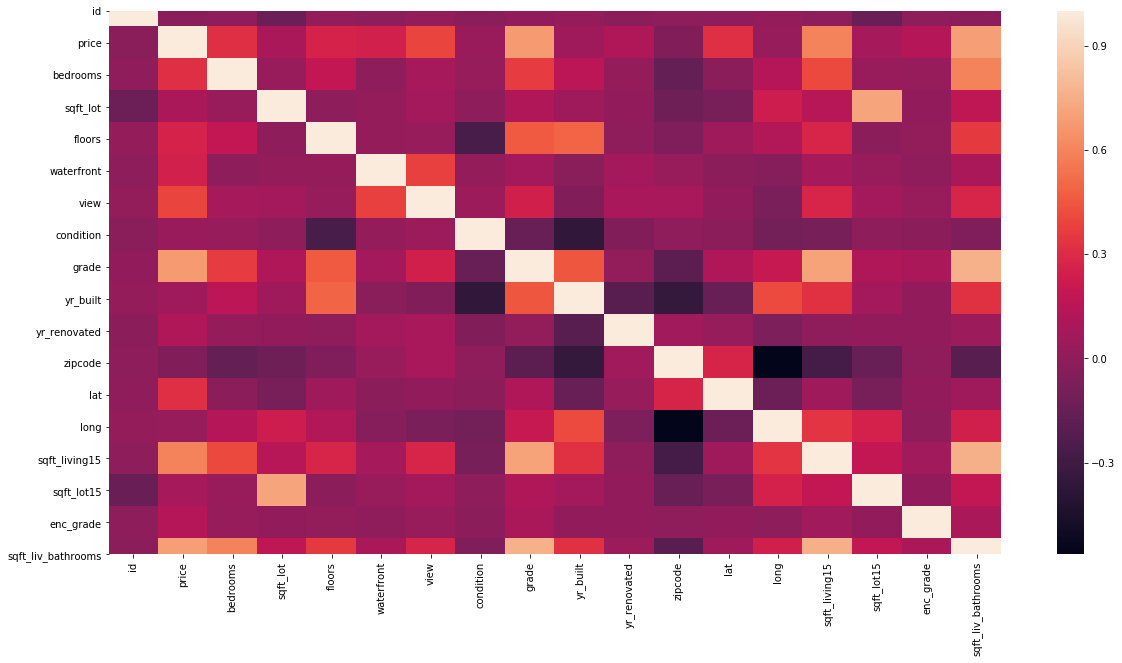

In [152]:
plt.figure(figsize = (20,10))
sns.heatmap(df3.corr())

In [204]:
used_cols2 = [c for c in df3.columns.to_list() if c not in [target]]

X2 = df3[used_cols2]
y2 = df3[target]
lr = Ridge(alpha=0.025)

pipe5 = make_pipeline(scaler, lr)
cv5 = cross_validate(pipe5, X2 , y2, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

test = cv5['test_r2'].mean()  
train= cv5['train_r2'].mean()  
    
print (f'test r2 is {test}')
print (f'train r2 is {train}')

test r2 is 0.7006323757928783
train r2 is 0.70614282730554


In [205]:
df3['sqft_liv_bathrooms_liv15'] = 0.5*df3['sqft_liv_bathrooms'] + 0.5*df3['sqft_living15']

In [206]:
df3.drop(columns=['sqft_liv_bathrooms','sqft_liv_bathrooms'],inplace=True)

In [207]:
used_cols2 = [c for c in df3.columns.to_list() if c not in [target]]

X2 = df3[used_cols2]
y2 = df3[target]
scaler = RobustScaler()
lr = LinearRegression()
pipe2 = make_pipeline(scaler, lr)
    
cv2 = cross_validate(pipe2, X2, y2, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

test = cv2['test_r2'].mean()  
train= cv2['train_r2'].mean()  
    
print (f'test r2 is {test}')
print (f'train r2 is {train}')

test r2 is 0.7006279459239123
train r2 is 0.7061428828997913


In [208]:
lr = Ridge(alpha=0.025)

pipe5 = make_pipeline(scaler, lr)
cv5 = cross_validate(pipe5, X2 , y2, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)

test = cv5['test_r2'].mean()  
train= cv5['train_r2'].mean()  
    
print (f'test r2 is {test}')
print (f'train r2 is {train}')

test r2 is 0.7006324544169678
train r2 is 0.7061428274699013


In [209]:


gam = LinearGAM(n_splines=25)
gam.gridsearch(X1.values, y1.values)
gam.summary()


100% (11 of 11) |########################| Elapsed Time: 0:01:43 Time:  0:01:43


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    299.3709
Link Function:                     IdentityLink Log Likelihood:                               -531251.9618
Number of Samples:                        21524 AIC:                                          1063104.6653
                                                AICc:                                         1063113.1961
                                                GCV:                                      21433602232.0657
                                                Scale:                                    20897670586.3005
                                                Pseudo R-Squared:                                   0.8325
Feature Function                  Lam

In [218]:
df_gams = df2.copy()

df_gams['lat_and_long'] = df_gams['long'] + df_gams['lat']

In [219]:
df_gams

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,enc_grade,lat_and_long
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,0,-74.7458
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,0,-74.5980
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,0,-74.4951
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,0,-74.8722
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,0,-74.4282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,0,-74.6467
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,0,-74.8513
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,0,-74.7046
21595,291310100,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287,0,-74.5345


In [220]:
used_cols_g = [c for c in df_gams.columns.to_list() if c not in [target]]

X_g = df_gams[used_cols_g]
y_g = df_gams[target]

In [221]:
gam = LinearGAM(n_splines=25)
gam.gridsearch(X_g.values, y_g.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:01:02 Time:  0:01:02


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    316.9225
Link Function:                     IdentityLink Log Likelihood:                               -530102.2098
Number of Samples:                        21524 AIC:                                          1060840.2646
                                                AICc:                                         1060849.8277
                                                GCV:                                      20349251195.1597
                                                Scale:                                     19810642052.702
                                                Pseudo R-Squared:                                   0.8414
Feature Function                  Lam

In [222]:
df_gams['lat_and_long_sq'] = df_gams['lat_and_long']**2
df_gams['lat_and_long_cubes'] = df_gams['lat_and_long']**3


In [224]:
used_cols_g = [c for c in df_gams.columns.to_list() if c not in [target]]

X_g = df_gams[used_cols_g]
y_g = df_gams[target]

In [225]:
gam = LinearGAM(n_splines=25)
gam.gridsearch(X_g.values, y_g.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:01:14 Time:  0:01:14


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     324.427
Link Function:                     IdentityLink Log Likelihood:                                 -530032.87
Number of Samples:                        21524 AIC:                                           1060716.594
                                                AICc:                                         1060726.6167
                                                GCV:                                      20296876274.6462
                                                Scale:                                    19746949907.4012
                                                Pseudo R-Squared:                                   0.8419
Feature Function                  Lam

In [226]:
df_gams['lat_sq'] = df_gams['lat']**2
df_gams['lat_cubes'] = df_gams['lat']**3
df_gams['long_sq'] = df_gams['long']**2
df_gams['long_sq'] = df_gams['long']**3

In [227]:
used_cols_g = [c for c in df_gams.columns.to_list() if c not in [target]]

X_g = df_gams[used_cols_g]
y_g = df_gams[target]

In [244]:
gam = LinearGAM(n_splines=50)
gam.gridsearch(X_g.values, y_g.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:04:41 Time:  0:04:41


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    611.5339
Link Function:                     IdentityLink Log Likelihood:                               -527526.9067
Number of Samples:                        21524 AIC:                                          1056278.8812
                                                AICc:                                         1056314.8259
                                                GCV:                                      18521400200.0472
                                                Scale:                                    17576657538.7283
                                                Pseudo R-Squared:                                   0.8612
Feature Function                  Lam

In [230]:
df_gams['zipcode'].value_counts()

98103    601
98038    586
98115    580
98052    573
98117    553
        ... 
98102    103
98010    100
98024     79
98148     57
98039     48
Name: zipcode, Length: 70, dtype: int64

In [245]:
df_zip1 = df_gams.loc[df_gams['zipcode']==98103]

In [246]:
df_zip1

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,enc_grade,lat_and_long,lat_and_long_sq,lat_and_long_cubes,lat_sq,lat_cubes,long_sq
17,6865200140,485000.0,4,1.00,1600,4300,1.5,0.0,0.0,4,7,1600,0.0,1916,0.0,98103,47.6648,-122.343,1610,4300,0,-74.6782,5576.833555,-416467.891605,2271.933159,108291.239639,-1.831207e+06
111,3362400511,570000.0,3,1.75,1260,3328,1.0,0.0,0.0,5,6,700,560.0,1905,0.0,98103,47.6823,-122.349,1380,3536,0,-74.6667,5575.116089,-416275.520474,2273.601733,108410.559927,-1.831476e+06
116,3362400431,518500.0,3,3.50,1590,1102,3.0,0.0,0.0,3,8,1590,0.0,2010,0.0,98103,47.6824,-122.347,1620,3166,0,-74.6646,5574.802493,-416240.398231,2273.611270,108411.242009,-1.831386e+06
128,2331300505,822500.0,5,3.50,2320,4960,2.0,0.0,0.0,5,7,1720,600.0,1926,0.0,98103,47.6763,-122.352,1700,4960,0,-74.6757,5576.460170,-416426.066753,2273.029582,108369.640246,-1.831611e+06
149,1994200024,511000.0,3,1.00,1430,3455,1.0,0.0,0.0,3,7,980,450.0,1947,0.0,98103,47.6873,-122.336,1450,4599,0,-74.6487,5572.428412,-415974.536776,2274.078581,108444.667530,-1.830892e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21551,9521100031,690000.0,3,3.25,1540,1428,3.0,0.0,0.0,3,9,1540,0.0,2013,0.0,98103,47.6648,-122.353,1660,3300,0,-74.6882,5578.327219,-416635.219016,2271.933159,108291.239639,-1.831656e+06
21558,1931300090,610950.0,3,3.00,1680,1570,3.0,0.0,0.0,3,8,1680,0.0,2014,0.0,98103,47.6572,-122.346,1640,4800,0,-74.6888,5578.416845,-416645.260086,2271.208712,108239.447822,-1.831341e+06
21576,1931300412,475000.0,3,2.25,1190,1200,3.0,0.0,0.0,3,8,1190,0.0,2008,0.0,98103,47.6542,-122.346,1180,1224,0,-74.6918,5578.864987,-416695.467854,2270.922778,108219.008230,-1.831341e+06
21579,1972201967,520000.0,2,2.25,1530,981,3.0,0.0,0.0,3,8,1480,50.0,2006,0.0,98103,47.6533,-122.346,1530,1282,0,-74.6927,5578.999433,-416710.530971,2270.837001,108212.876855,-1.831341e+06


In [247]:
used_cols_zip = [c for c in df_zip1.columns.to_list() if c not in [target]]

X_zip = df_zip1[used_cols_zip]
y_zip = df_zip1[target]

In [248]:
gam = LinearGAM(n_splines=50)
gam.gridsearch(X_zip.values, y_zip.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:54 Time:  0:00:54


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    150.5901
Link Function:                     IdentityLink Log Likelihood:                                 -14353.925
Number of Samples:                          601 AIC:                                            29011.0303
                                                AICc:                                           29114.1999
                                                GCV:                                      16722677687.1775
                                                Scale:                                     9404587822.9945
                                                Pseudo R-Squared:                                   0.8391
Feature Function                  Lam

In [249]:
df_zip2 = df_gams.loc[df_gams['zipcode']==98039]

In [250]:
used_cols_zip2 = [c for c in df_zip2.columns.to_list() if c not in [target]]

X_zip2 = df_zip2[used_cols_zip2]
y_zip2 = df_zip2[target]

In [251]:
gam = LinearGAM(n_splines=50)
gam.gridsearch(X_zip2.values, y_zip2.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:35 Time:  0:00:35


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     46.9802
Link Function:                     IdentityLink Log Likelihood:                                 -1073.8612
Number of Samples:                           48 AIC:                                             2243.6829
                                                AICc:                                           -2551.4164
                                                GCV:                                        321560897.6775
                                                Scale:                                     2074883107.1117
                                                Pseudo R-Squared:                                   0.9999
Feature Function                  Lam

In [252]:
df_zip3 = df_gams.loc[df_gams['zipcode']==98102]

In [253]:
used_cols_zip3 = [c for c in df_zip3.columns.to_list() if c not in [target]]

X_zip3 = df_zip3[used_cols_zip3]
y_zip3 = df_zip3[target]

In [255]:
gam = LinearGAM(n_splines=50)
gam.gridsearch(X_zip3.values, y_zip3.values)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:37 Time:  0:00:37


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     97.4913
Link Function:                     IdentityLink Log Likelihood:                                 -2160.7503
Number of Samples:                          103 AIC:                                             4518.4831
                                                AICc:                                            10103.997
                                                GCV:                                        260449552.7503
                                                Scale:                                      514763681.0202
                                                Pseudo R-Squared:                                   0.9998
Feature Function                  Lam